In [17]:
import os
import torch
import torchaudio
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
import plotly.express as px
from collections import defaultdict
from tqdm import tqdm
import lightgbm as lgb

In [6]:
print(torchaudio.info("/kaggle/input/birdclef-2023/train_audio/abhori1/XC120250.ogg"))

AudioMetaData(sample_rate=32000, num_frames=1216261, num_channels=1, bits_per_sample=0, encoding=VORBIS)


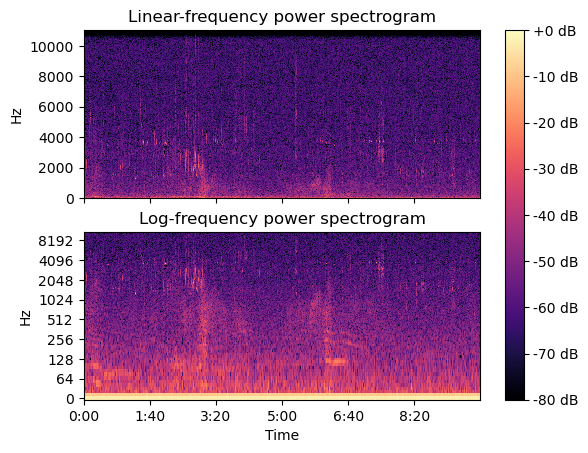

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [13]:
pd.read_csv("/kaggle/input/birdclef-2023/sample_submission.csv")

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,soundscape_29201_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,soundscape_29201_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
metadata = pd.read_csv("/kaggle/input/birdclef-2023/train_metadata.csv")
metadata

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...
16936,yewgre1,[],[''],-1.2502,29.7971,Eurillas latirostris,Yellow-whiskered Greenbul,András Schmidt,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://xeno-canto.org/703472,yewgre1/XC703472.ogg
16937,yewgre1,[],[''],-1.2489,29.7923,Eurillas latirostris,Yellow-whiskered Greenbul,András Schmidt,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/703485,yewgre1/XC703485.ogg
16938,yewgre1,[],[''],-1.2433,29.7844,Eurillas latirostris,Yellow-whiskered Greenbul,András Schmidt,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/704433,yewgre1/XC704433.ogg
16939,yewgre1,[],[''],0.0452,36.3699,Eurillas latirostris,Yellow-whiskered Greenbul,Lars Lachmann,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://xeno-canto.org/752974,yewgre1/XC752974.ogg


In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16941 entries, 0 to 16940
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     16941 non-null  object 
 1   secondary_labels  16941 non-null  object 
 2   type              16941 non-null  object 
 3   latitude          16714 non-null  float64
 4   longitude         16714 non-null  float64
 5   scientific_name   16941 non-null  object 
 6   common_name       16941 non-null  object 
 7   author            16941 non-null  object 
 8   license           16941 non-null  object 
 9   rating            16941 non-null  float64
 10  url               16941 non-null  object 
 11  filename          16941 non-null  object 
dtypes: float64(3), object(9)
memory usage: 1.6+ MB


In [16]:
metadata.nunique()

primary_label         264
secondary_labels      751
type                  796
latitude             6252
longitude            6301
scientific_name       264
common_name           264
author               1082
license                 4
rating                 11
url                 16941
filename            16941
dtype: int64

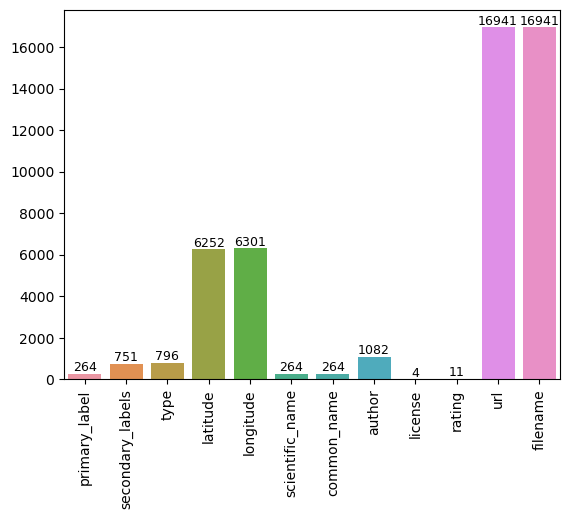

In [58]:
fig, axes = plt.subplots(1, 1)
df = metadata
sns.barplot(x=df.columns, y=df.nunique())
plt.xticks(rotation=90)

for i, v in enumerate(df.columns):
    plt.text(i, metadata.nunique()[i], metadata.nunique()[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')
    
plt.show()

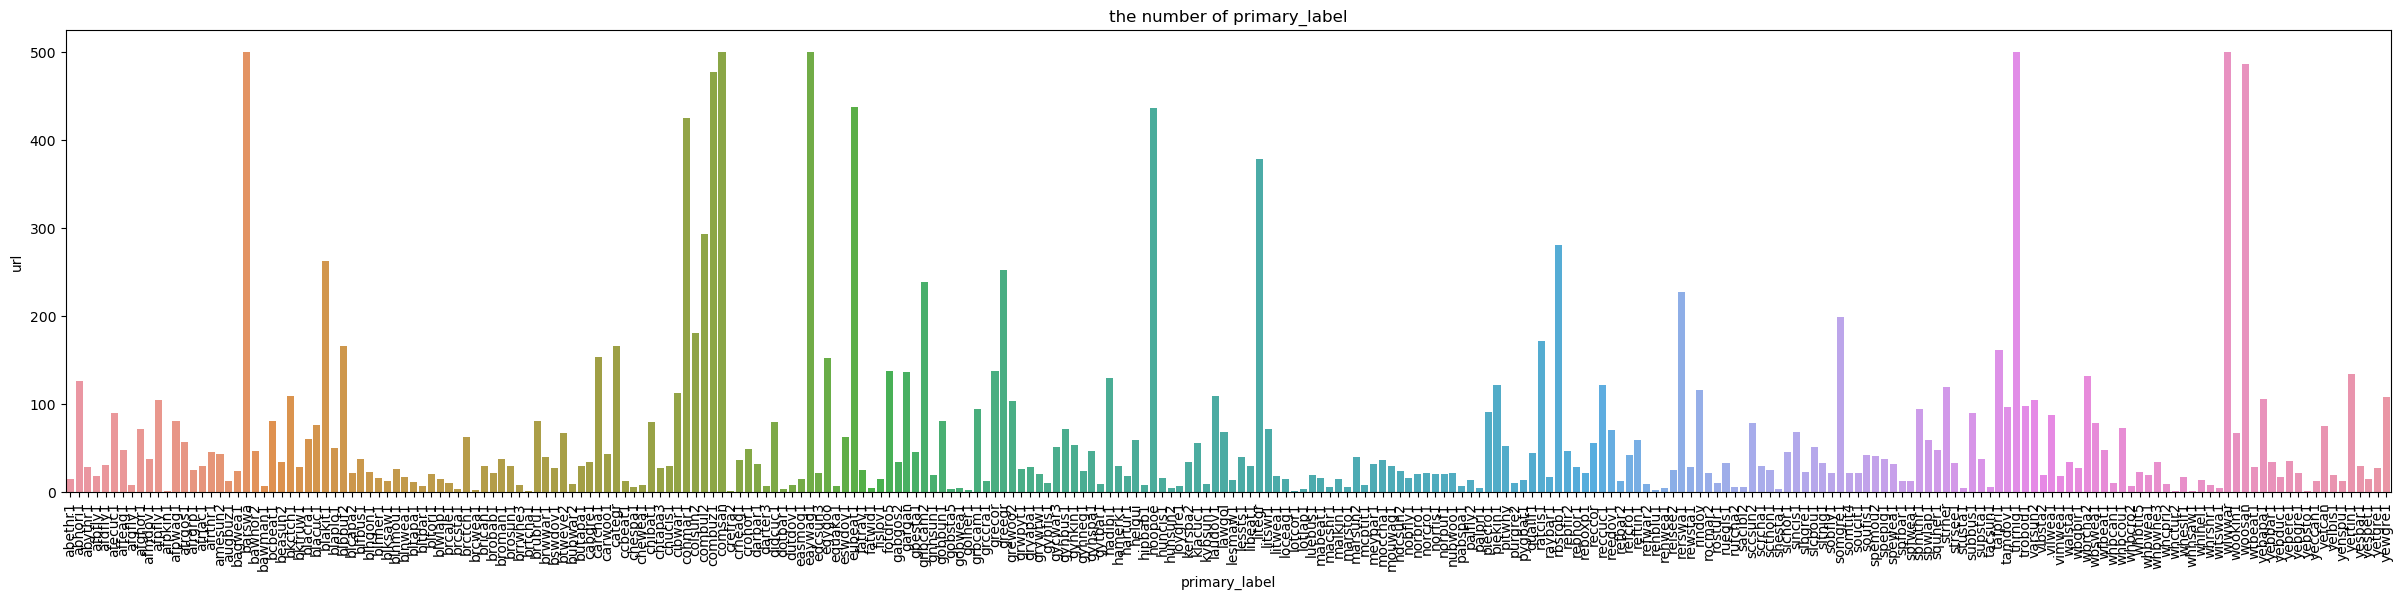

In [61]:
fig, axes = plt.subplots(1, 1, figsize=(30,6))
df = metadata.groupby("primary_label").nunique()
sns.barplot(x=df.index , y=df["url"])
plt.title("the number of primary_label")
plt.xticks(rotation=90)
plt.show()

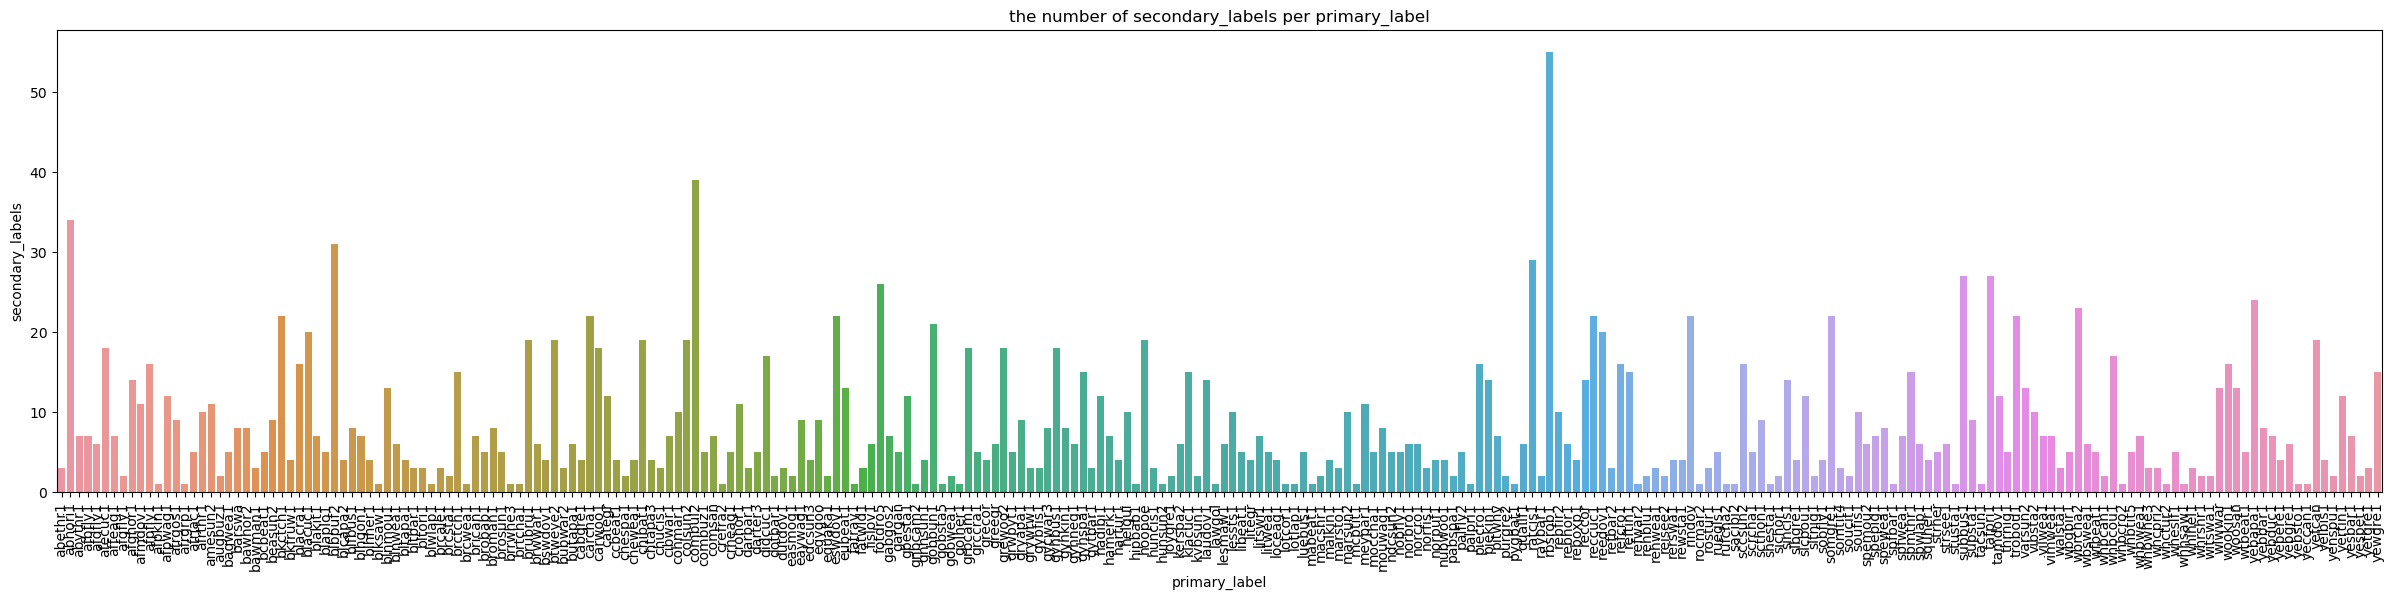

In [56]:
fig, axes = plt.subplots(1, 1, figsize=(30,6))
df = metadata.groupby("primary_label").nunique()
sns.barplot(x=df.index, y=df["secondary_labels"])
plt.title("the number of secondary_labels per primary_label")
plt.xticks(rotation=90)
plt.show()

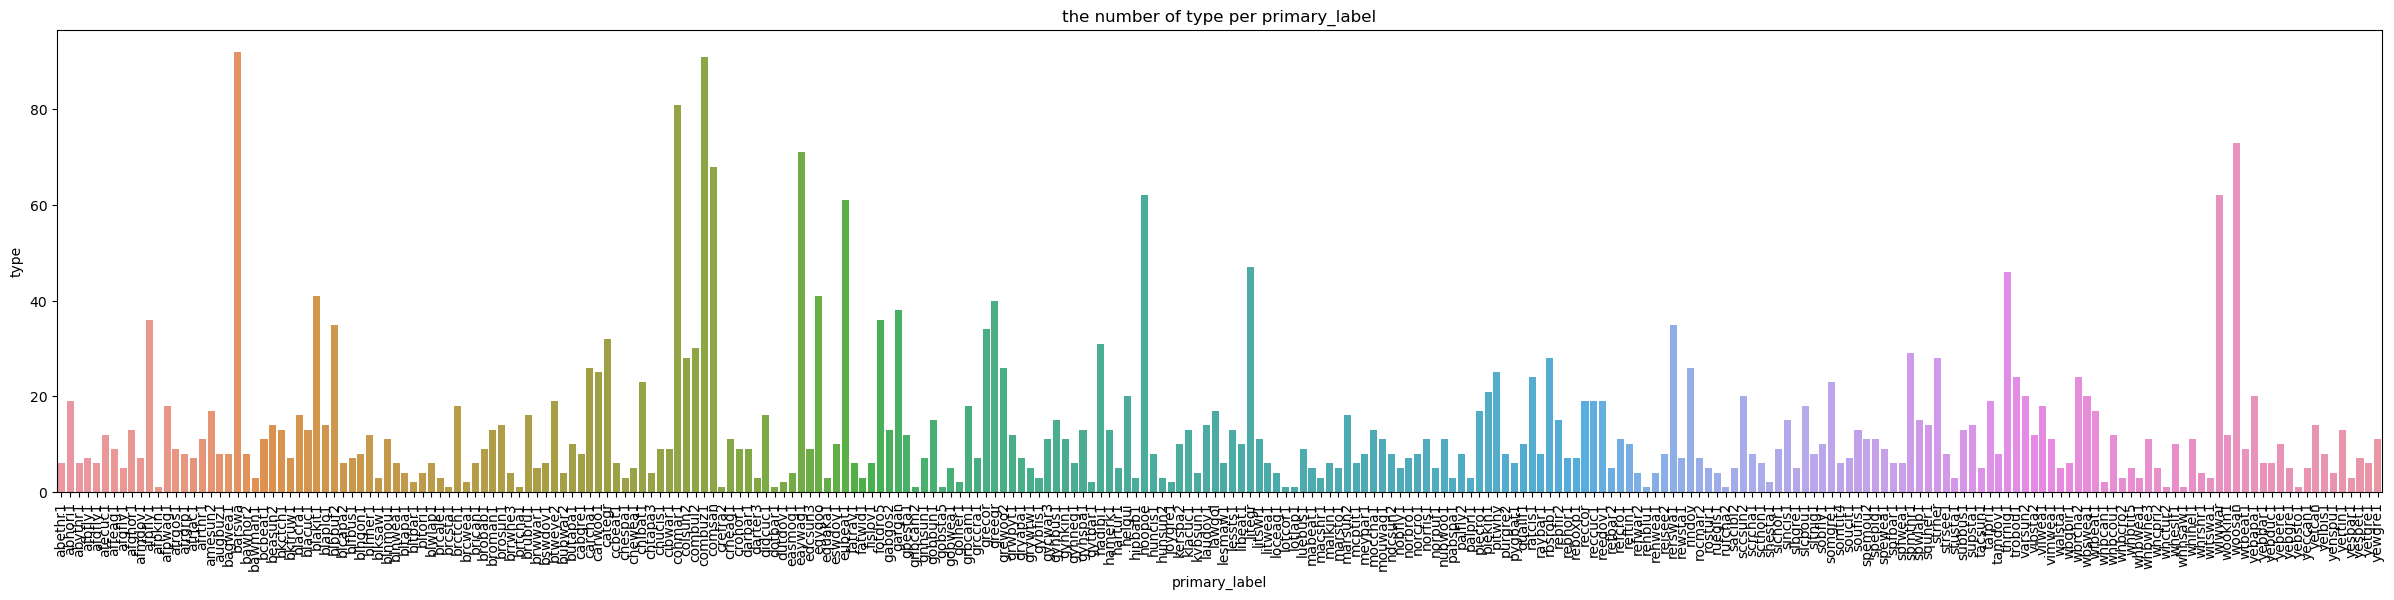

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(30,6))
df = metadata.groupby("primary_label").nunique()
sns.barplot(x=df.index, y=df["type"])
plt.title("the number of type per primary_label")
plt.xticks(rotation=90)
plt.show()

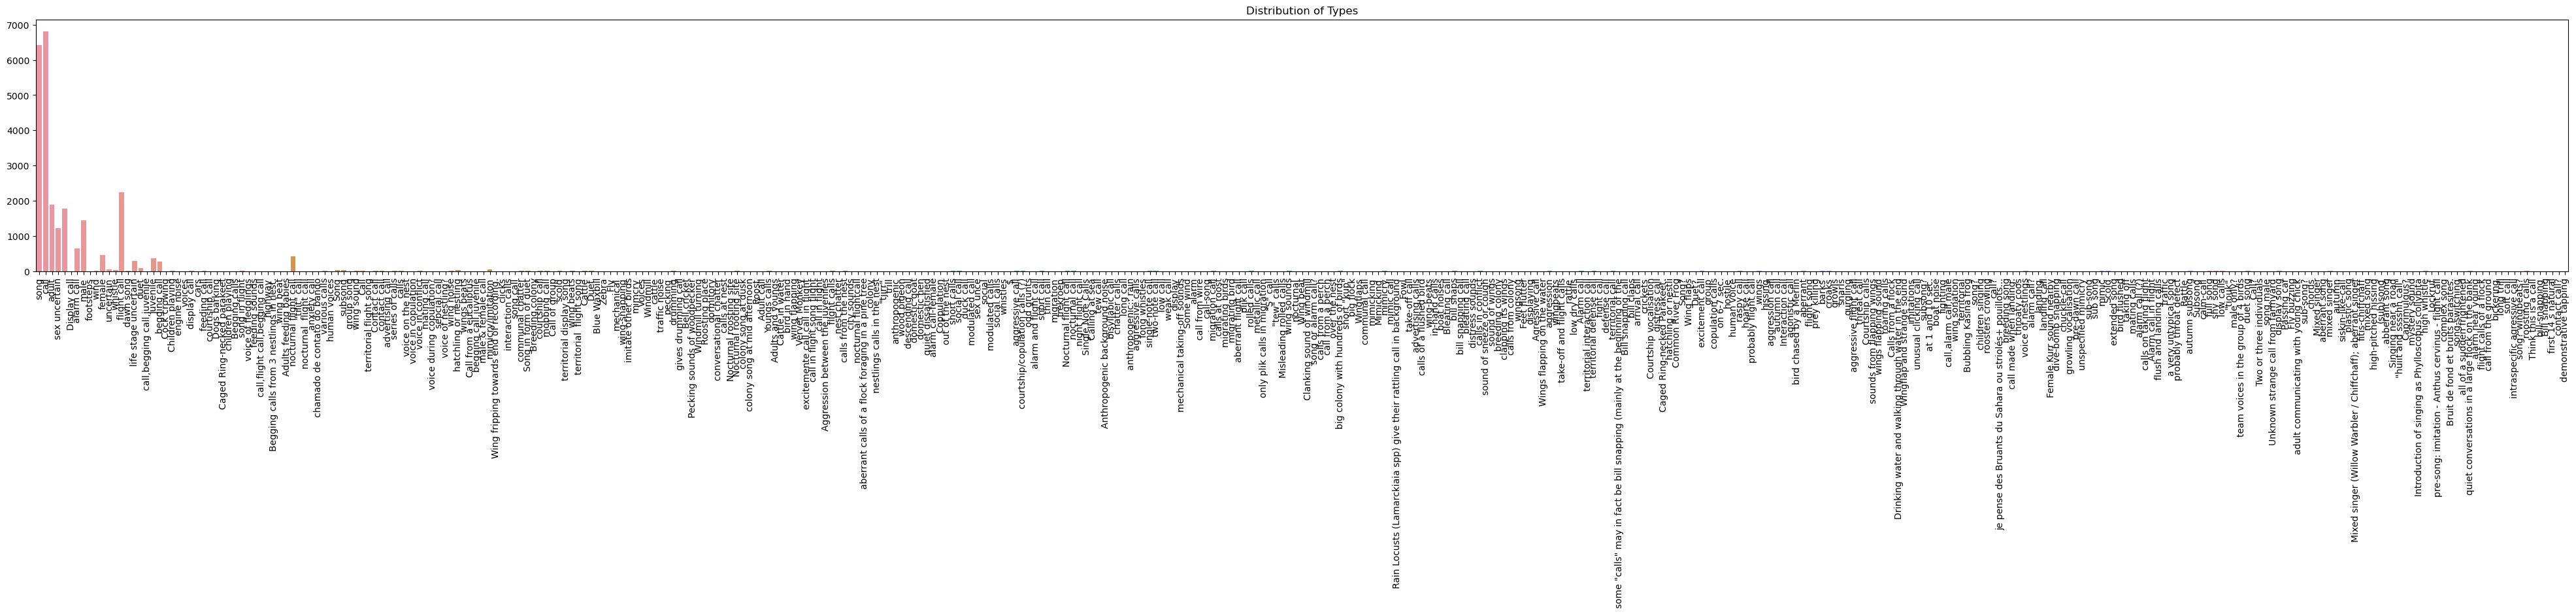

In [77]:
# Flatten the list of labels in the "type" column
labels = [label.strip("[]'") for sublist in metadata['type'].apply(ast.literal_eval) for label in sublist]

# Count the occurrence of each label
label_counts = Counter(labels)

# Create a bar plot of the label counts
fig, axes = plt.subplots(1, 1, figsize=(50,5))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Distribution of Types")
plt.xticks(rotation=90)
plt.show()

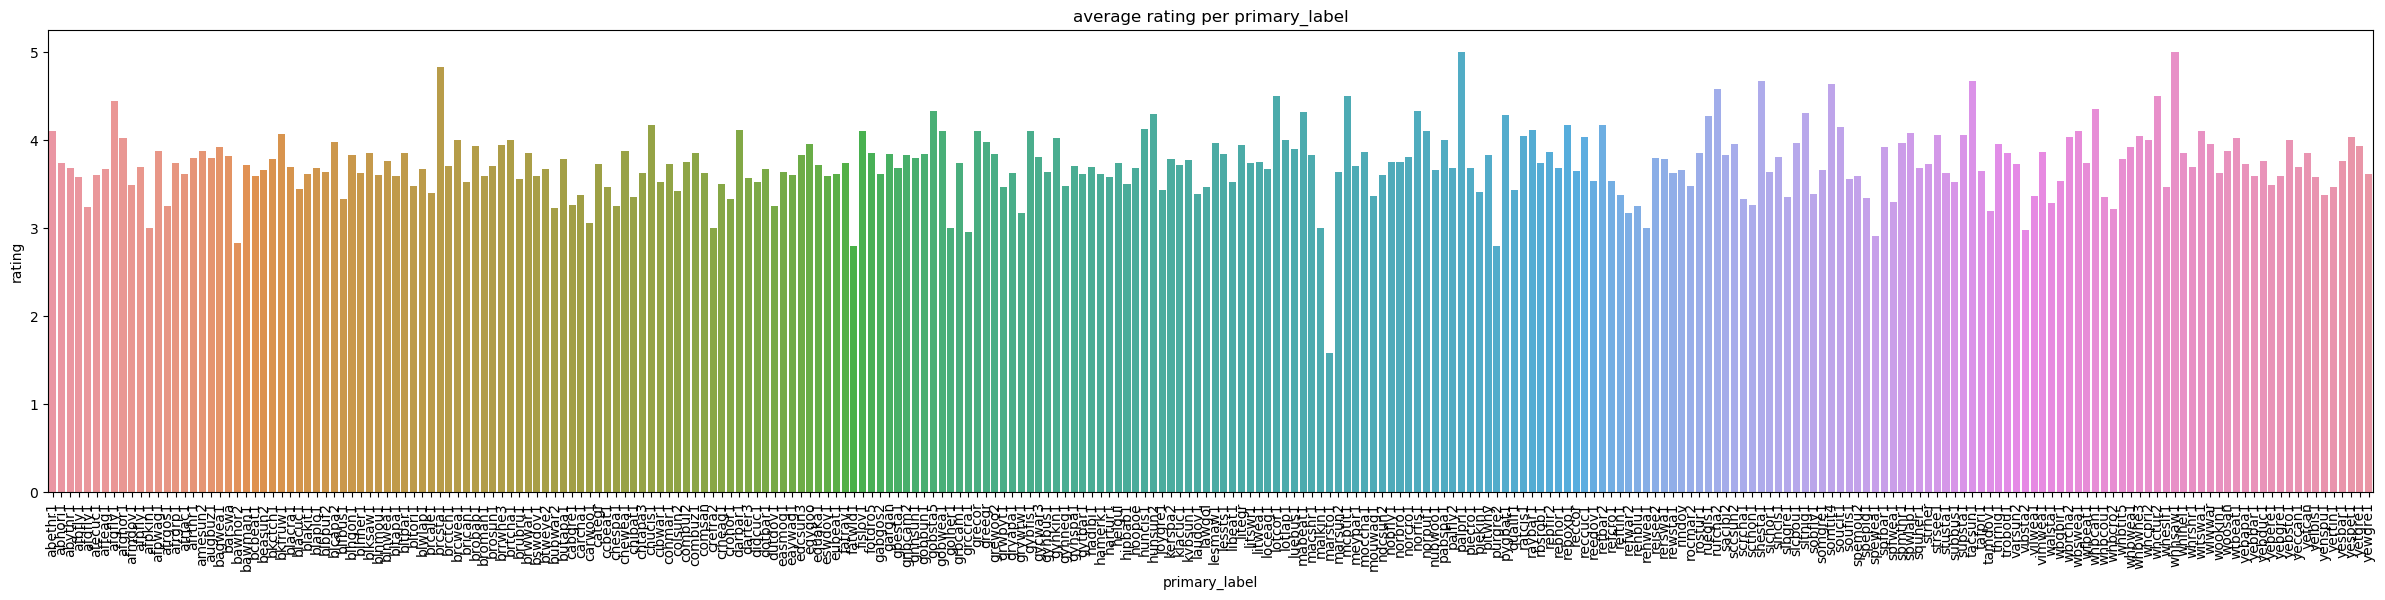

In [55]:
fig, axes = plt.subplots(1, 1, figsize=(30,6))
df = metadata.groupby("primary_label").mean()
sns.barplot(x=df.index , y=df["rating"])
plt.title("average rating per primary_label")
plt.xticks(rotation=90)
plt.show()

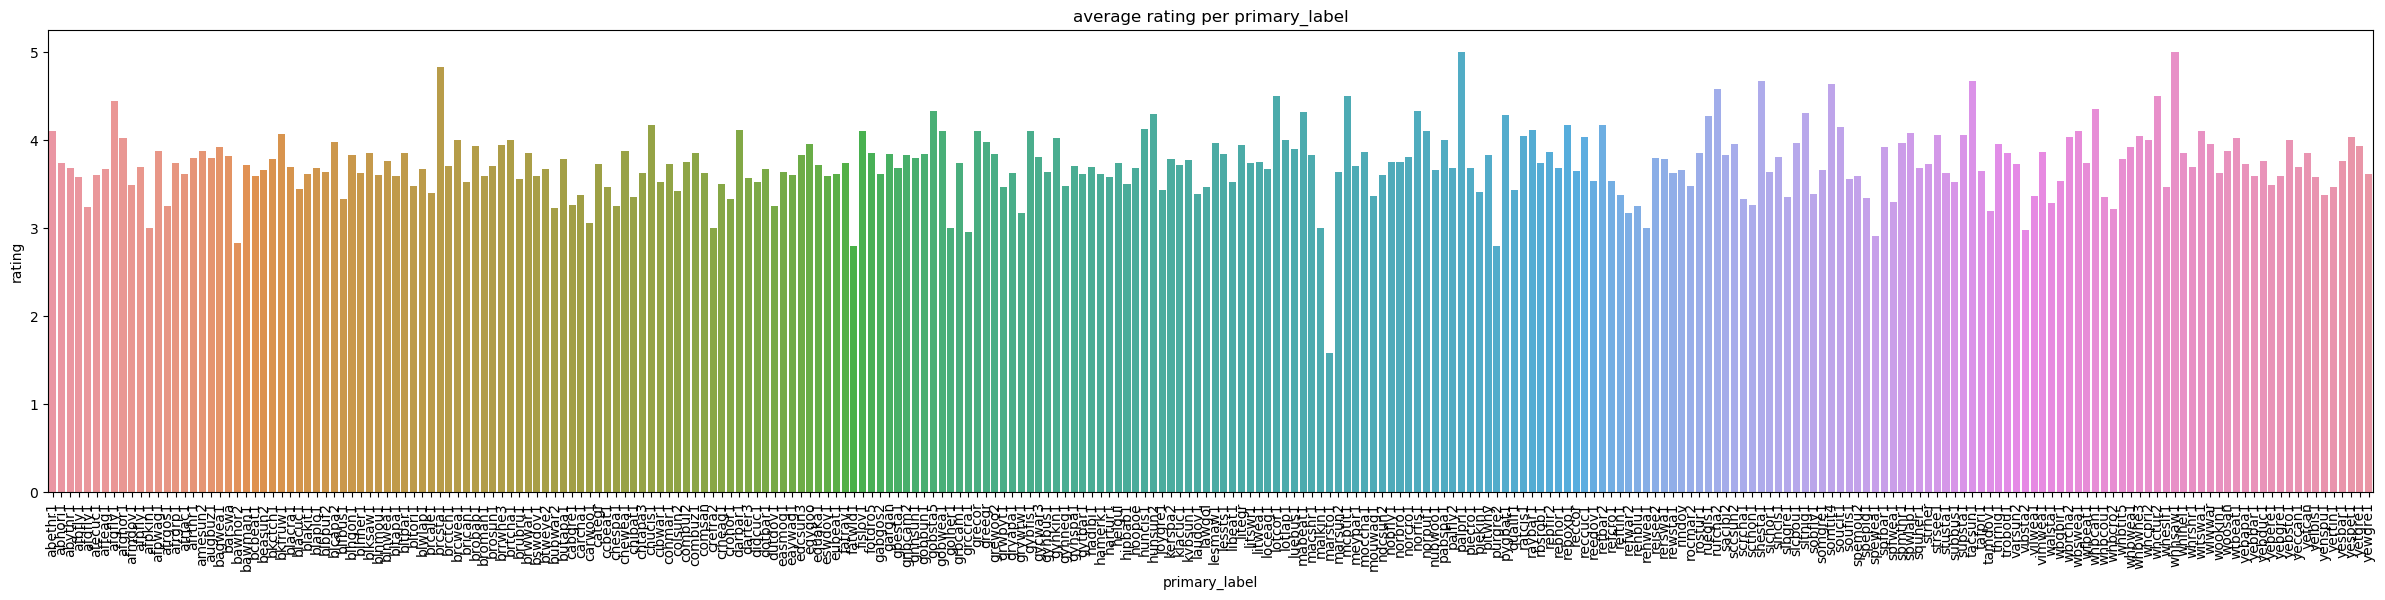

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(30,6))
df = metadata.groupby("primary_label").mean()
sns.barplot(x=df.index , y=df["rating"])
plt.title("average rating per primary_label")
plt.xticks(rotation=90)
plt.show()

In [17]:
fig = px.scatter(metadata, x="longitude", y="latitude", color="common_name")
fig.update_layout(title="Distribution of Recordings by Location")
fig.show()

In [20]:
def audio_eda(audio_path):
   
    # Load an audio file
    waveform, sample_rate = torchaudio.load(SAMPLE_WAV)
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    # Visualize the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(torch.arange(waveform.numel()).numpy() / sample_rate, waveform.t().numpy())
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform')

    
    # Compute the spectrogram
    hop_length=200
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=400, hop_length=hop_length)(waveform)
    log_spectrogram = torchaudio.transforms.AmplitudeToDB()(spectrogram)

    # Visualize the spectrogram
    num_columns = log_spectrogram.shape[2]
    time_step = float(hop_length) / sample_rate
    times = np.arange(num_columns) * time_step
    fig, ax = plt.subplots(figsize=(10, 4))
    img = ax.imshow(log_spectrogram.squeeze(), aspect='auto', cmap='magma', origin='lower')
    num_ticks = 10
    step_size = int(num_columns / num_ticks)
    ax.set_xticks(np.arange(0, num_columns, step_size))
    ax.set_xticklabels(['{:.2f}'.format(t) for t in times[::step_size]])
    ax.set_xlabel('Time (s)')
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

    
    # Compute the mel spectrogram
#     transform = transforms.MelSpectrogram(sample_rate)
    melspectrogram = torchaudio.transforms.MelSpectrogram(n_fft=400, hop_length=hop_length)(waveform)
    log_melspectrogram = torchaudio.transforms.AmplitudeToDB()(melspectrogram)

    # Visualize the mel spectrogram
    num_columns = log_melspectrogram.shape[2]
    time_step = float(hop_length) / sample_rate
    times = np.arange(num_columns) * time_step
    fig, ax = plt.subplots(figsize=(10, 4))
    img = ax.imshow(log_melspectrogram.squeeze(), aspect='auto', cmap='magma', origin='lower')
    num_ticks = 10
    step_size = int(num_columns / num_ticks)
    ax.set_xticks(np.arange(0, num_columns, step_size))
    ax.set_xticklabels(['{:.2f}'.format(t) for t in times[::step_size]])
    ax.set_xlabel('Time (s)')
    fig.colorbar(img, ax=ax, format='%+2.0f dB')


#     # Compute the chromagram
#     chromagram = librosa.feature.chroma_stft(y = samples , sr = sample_rate)

#     # Visualize the chromagram
#     plt.figure(figsize=(14, 5))
#     librosa.display.specshow(chromagram, sr=sample_rate, x_axis='time', y_axis='chroma')
#     plt.colorbar()
#     plt.title('Chromagram')

    
    # Compute the MFCCs
    mfcc_transform = torchaudio.transforms.MFCC(sample_rate=sample_rate)
    mfcc = mfcc_transform(waveform).detach().numpy()

    # Visualize the MFCCs
    num_frames = mfcc.shape[2]
    time_step = float(hop_length) / sample_rate
    times = np.arange(num_frames) * time_step

    # Create figure and plot MFCC
    fig, ax = plt.subplots(figsize=(10, 4))
    img = ax.imshow(mfcc.squeeze(), aspect='auto', cmap='jet', origin='lower')

    # Set time axis labels
    num_ticks = 10
    step_size = int(num_frames / num_ticks)
    ax.set_xticks(np.arange(0, num_frames, step_size))
    ax.set_xticklabels(['{:.2f}'.format(t) for t in times[::step_size]])
    ax.set_xlabel('Time (s)')

    # Add colorbar
    fig.colorbar(img, ax=ax, format='%+2.0f')


    # Show the plots
#     display(Audio(samples, rate=sample_rate))
    plt.show()

In [21]:
SAMPLE_WAV = "/kaggle/input/birdclef-2023/train_audio/abethr1/XC128013.ogg"

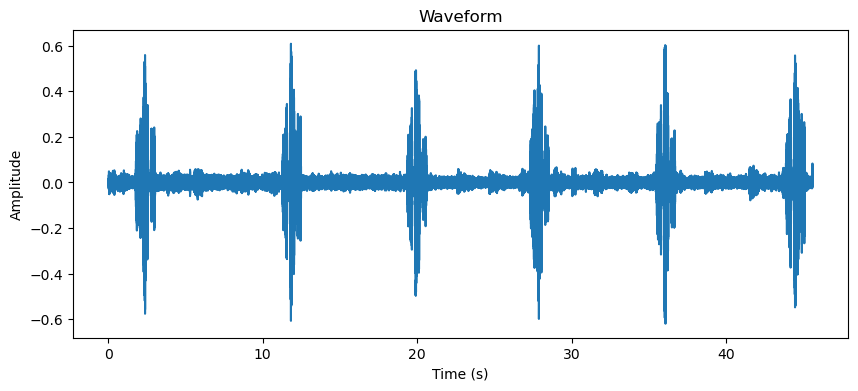

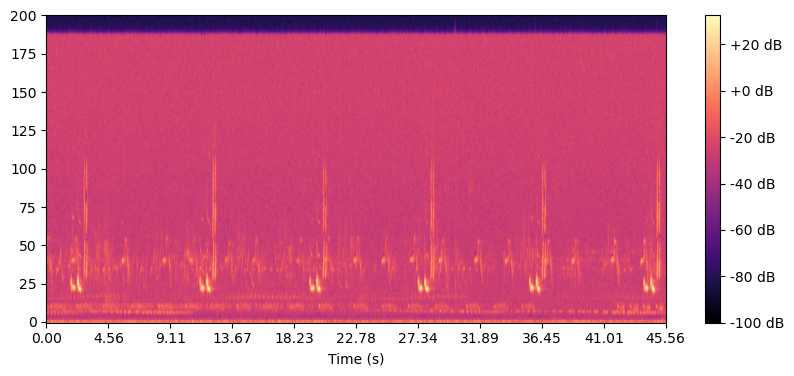

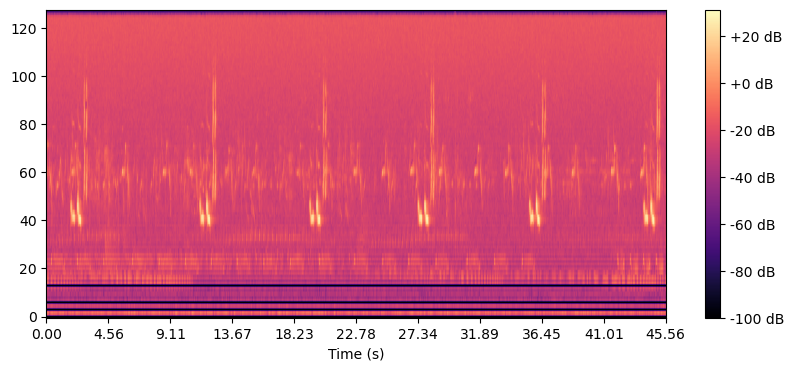

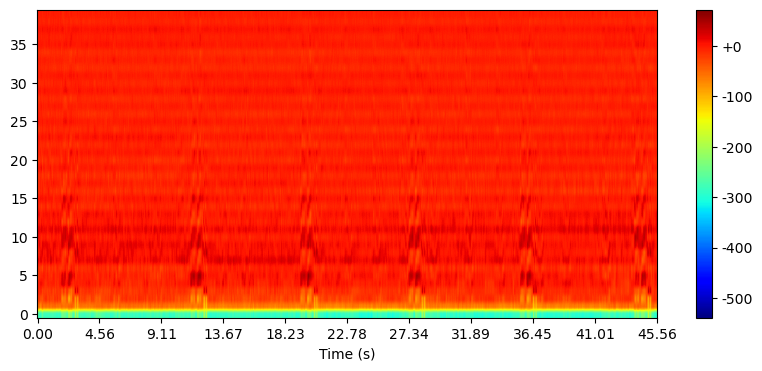

In [22]:
audio_eda(SAMPLE_WAV)

In [2]:
train_audio = sorted(os.listdir("/kaggle/input/birdclef-2023/train_audio"))

In [39]:
waveform, sample_rate = torchaudio.load("/kaggle/input/birdclef-2023/train_audio/abethr1/XC128013.ogg")
spectro = torchaudio.transforms.Spectrogram()(waveform)
melspectro = torchaudio.transforms.MelSpectrogram()(waveform)
mfcc = torchaudio.transforms.MFCC()(waveform)

In [41]:
waveform, waveform.shape

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -9.1553e-05,
           9.4604e-04,  9.1553e-04]]),
 torch.Size([1, 1459513]))

In [46]:
waveform.mean()

tensor(8.3398e-06)

In [47]:
waveform.std()

tensor(0.0506)

In [43]:
spectro, spectro.shape

(tensor([[[3.0907e-10, 7.5068e-07, 5.1029e-06,  ..., 1.8034e-01,
           1.3778e-02, 5.7454e-02],
          [1.7142e-08, 1.7681e-06, 1.6259e-05,  ..., 6.9537e-02,
           1.0120e-03, 4.1294e-02],
          [1.1562e-07, 3.2967e-06, 1.6180e-05,  ..., 4.1233e-02,
           1.6188e-03, 1.4829e-02],
          ...,
          [1.3200e-08, 1.6405e-10, 8.9340e-09,  ..., 2.2483e-08,
           6.3468e-11, 1.1803e-07],
          [5.7313e-08, 5.3528e-09, 7.7161e-09,  ..., 3.6459e-08,
           2.0741e-09, 1.6689e-07],
          [1.1882e-07, 1.5733e-08, 1.3446e-10,  ..., 2.0103e-08,
           3.9787e-09, 2.3498e-07]]]),
 torch.Size([1, 201, 7298]))

In [44]:
melspectro, melspectro.shape

(tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.6851e-09, 2.7694e-07, 2.5467e-06,  ..., 1.0892e-02,
           1.5852e-04, 6.4680e-03],
          [1.4457e-08, 1.4911e-06, 1.3712e-05,  ..., 5.8645e-02,
           8.5350e-04, 3.4826e-02],
          ...,
          [9.5517e-08, 1.4167e-06, 1.1838e-05,  ..., 1.7013e-03,
           6.3231e-04, 2.9005e-04],
          [6.7860e-08, 3.5026e-06, 1.8778e-05,  ..., 1.3788e-05,
           5.5428e-06, 3.4667e-06],
          [2.4127e-08, 3.0402e-07, 2.8072e-07,  ..., 5.9280e-08,
           1.4706e-08, 7.0639e-07]]]),
 torch.Size([1, 128, 7298]))

In [45]:
mfcc, mfcc.shape

(tensor([[[-5.5109e+02, -5.5109e+02, -5.4038e+02,  ..., -3.5176e+02,
           -3.9312e+02, -4.3237e+02],
          [ 8.4587e-06,  8.4587e-06, -1.7666e+00,  ...,  1.4369e-01,
           -2.2941e+01, -1.3086e+01],
          [-3.6810e-05, -3.6810e-05, -2.3294e+00,  ...,  7.1430e+00,
           -6.8206e+00,  5.7745e+00],
          ...,
          [ 6.1750e-05,  6.1750e-05,  4.9235e-01,  ..., -1.0897e+01,
           -5.4461e+00, -2.8396e+00],
          [-1.5372e-04, -1.5372e-04, -2.2636e+00,  ..., -1.7822e+01,
           -2.1826e+00, -4.0845e+00],
          [-1.3471e-04, -1.3471e-04, -3.8900e-01,  ..., -3.9972e+00,
           -8.0426e-02, -5.4735e+00]]]),
 torch.Size([1, 40, 7298]))

In [8]:
features = defaultdict(list)

In [9]:
PATH = "/kaggle/input/birdclef-2023/train_audio/"

In [10]:
for primary_label in tqdm(train_audio):
    waveform_mean_box = []
    spectro_mean_box = []
    melspectro_mean_box = []
    mfcc_mean_box = []
    waveform_std_box = []
    spectro_std_box = []
    melspectro_std_box = []
    mfcc_std_box = []
    for file in sorted(os.listdir(PATH+primary_label)):
        waveform, sample_rate = torchaudio.load(PATH+primary_label+"/"+file)
        spectro = torchaudio.transforms.Spectrogram()(waveform)
        melspectro = torchaudio.transforms.MelSpectrogram()(waveform)
        mfcc = torchaudio.transforms.MFCC()(waveform)
        
        features["waveform_mean"].append(waveform.mean())
        features["spectro_mean"].append(spectro.mean())
        features["melspectro_mean"].append(melspectro.mean())
        features["mfcc_mean"].append(mfcc.mean())
        features["waveform_std"].append(waveform.std())
        features["spectro_std"].append(spectro.std())
        features["melspectro_std"].append(melspectro.std())
        features["mfcc_std"].append(mfcc.std())

  0%|          | 0/264 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:572: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
100%|██████████| 264/264 [30:00<00:00,  6.82s/it] 


In [11]:
features.shape

AttributeError: 'collections.defaultdict' object has no attribute 'shape'

In [26]:
df = pd.DataFrame(data=features)
df = df.applymap(lambda x: x.item())

In [27]:
df = pd.concat([metadata, df], axis=1)

In [36]:
df = df.groupby("primary_label").mean().reset_index()

In [38]:
birds = df["primary_label"].unique()
train_bird = birds[:int(len(birds)*0.8)]
valid_bird = birds[int(len(birds)*0.8):]

In [39]:
train = df[df["primary_label"].isin(train_bird)]
valid = df[df["primary_label"].isin(valid_bird)]

In [50]:
X_train = train.drop(columns="primary_label")
y_train = train[["primary_label"]]
X_valid = valid.drop(columns="primary_label")
y_valid = valid[["primary_label"]]

In [51]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

In [52]:
params = {
    'objective': 'multiclass',
    'num_class': df["primary_label"].nunique(),
    'metric': 'multi_logloss'
}

In [53]:
model = lgb.train(params=params, train_set=train_data, valid_sets=[valid_data])

ValueError: DataFrame.dtypes for label must be int, float or bool